# SBPP-GAUGE - Precipitation Data
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@description**:  Unificacion de los datasets de UTE, IMERG, PERSIANN y CHIRPS. Unificacion de los datasets de INUMET, IMERG, PERSIANN y CHIRPS.
 - **Data Source**:  
 - **Output**: 
  -  view_ute_sbpp_2000_2020.pkl
  -  view_inumet_sbpp_2000_2020.pkl
  -  ute_sbpp_nearest_neighbors_2000_2020.pkl
  -  inumet_sbpp_nearest_neighbors_2000_2020.pkl 
  -  master_view_ute_sbpp_2000_2020.pkl
  -  master_view_inumet_sbpp_2000_2020.pkl
  -  master_ute_sbpp_nearest_neighbors_2000_2020.pkl
  -  master_inumet_sbpp_nearest_neighbors_2000_2020.pkl

 - **Input**: 
   - master_ute_daily_2000_2020_ext.nc
   - master_inumet_daily_2000_2020_ext.nc
   - master_imerg_late_daily_2000_2020_ext.nc
   - master_imerg_final_daily_2000_2020_ext.nc
   - master_chirps_daily_2000_2020_ext.nc
   - master_persiann_daily_2000_2020_ext.nc


 - **@version**: v1.3
 - **@date**: 2022-08-10,  2022-08-06, 2022-08-01, 2022-07-30, 2022-07-25   


In [1]:
# %reset-f
 


## Setup

In [2]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/06 - Merge SBPP Gauge/"
dir_google_drive_output = dir_google_drive+'/datasets/output/'
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_data_shapefiles = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'
dir_tmp = dir_var+'/tmp/'

# Important
# digits_round_satellite = 3
# digits_round_gauge     = 4

### Libraries

In [3]:
# %whos

In [4]:
# https://pypi.org/project/wget/
# !pip install wget

In [5]:
!sudo apt-get -y install netcdf-bin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  netcdf-bin
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 189 kB of archives.
After this operation, 524 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 netcdf-bin amd64 1:4.6.0-2build1 [189 kB]
Fetched 189 kB in 0s (1,020 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [6]:
!pip install geopandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 16.7 MB 255 kB/s 
     |████████████████████████████████| 6.3 MB 28.9 MB/s 


In [7]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
# import wget
import os 
import shutil
import glob
import calendar

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [8]:
# sklearn Nearstest Neighbors
from sklearn.neighbors import BallTree
from sklearn.metrics import DistanceMetric
# from sklearn.neighbors import BallTree, DistanceMetric

In [9]:
def get_lat_lon(df,lat='lat',lon='lon'):
  df_ = df.reset_index()[[lat,lon]]
  return df_.drop_duplicates().reset_index(drop=True) 


In [10]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay

In [11]:
def get_lat_lon_with_values_xarray(filename_nc):
  ds_xr = xr.open_dataset(filename_nc)#, mask_and_scale=False)
  mask = ds_xr.precipitation >= -999; 
  ds_xr = ds_xr.where( mask, drop=True )

  print('Lats:', len(ds_xr.lat.values) , 'Lons: ',len(ds_xr.lon.values) ) # 19 * 22 = 418

  
  df_ = ds_xr.sum(dim="time").to_dataframe()
  print('All Data:', df_.shape)
  # df_ = df_[df_['precipitation']>0]  # 276 solo tienen datos !!!!! 
  # df_ = df_[~df_['precipitation'].isnull()]
  df_ = df_.dropna()
  print('With Data:', df_.shape)

  df_ = df_.reset_index()[['lat','lon']]
  df_ = df_.drop_duplicates()
  print('lat_lon without duplicates:', df_.shape)

  df_lat = df_['lat'].drop_duplicates()
  df_lon = df_['lon'].drop_duplicates()
  print('lats:', df_lat.shape, 'lons:', df_lon.shape)
  return df_




###### nearest_neighbor

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html
# The problem is that the tutorial code provides coordinates in Longitude, Latitude format instead of the Latitude, Longitude format BallTree anticipates. So you're measuring distances between inverted points.

                         # Building (de donde parto) -> Stops(a donde quiero ir)
def get_nearest_neighbor(df_sources, df_candidates, source, metric='haversine'):

  # Distance haversine
  if metric == 'haversine':
    candidates_coords = np.radians(df_candidates[['lon','lat']]) # haversine
  else:
    candidates_coords = df_candidates[['lon','lat']] 
  
  # candidates_dist = DistanceMetric.get_metric('haversine') 
  # candidates_tree = BallTree(candidates_coords, metric=candidates_dist)
  candidates_tree = BallTree(candidates_coords, metric=metric)


  if metric == 'haversine':
    source_coords = np.radians(df_sources[['lon','lat']])
  else:
    source_coords = df_sources[['lon','lat']]

  # calculo distancias
  distances_candidates, indices_candidates = candidates_tree.query(source_coords, k=1)

  df_ = df_sources.copy()
  df_[source+'_lat'] = df_candidates['lat'].iloc[indices_candidates.flatten()].values
  df_[source+'_lon'] = df_candidates['lon'].iloc[indices_candidates.flatten()].values

  earth_radius = 6371  # km
  distances_candidates = distances_candidates * earth_radius

  df_[source+'_distance'] = distances_candidates.flatten()
  df_[source+'_source'] = source
  
  return df_


#### Spark

In [13]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 35 kB/s 
     |████████████████████████████████| 199 kB 42.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=86ca68e275cf1315e81599fef3d76fc5ea10879e9949c943dc1e4e7b089d49e0
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [14]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession

from joblib import Parallel, delayed
from pyspark.sql.functions import when, lit, col, to_date
from pyspark.sql import functions as F
import time


In [15]:
def getSparkSession():
  spark = SparkSession.builder \
                  .master("local[*]") \
                  .config("spark.executor.memory", "70g") \
                  .config("spark.driver.memory", "50g") \
                  .config("spark.driver.maxResultSize", "50g") \
                  .config("spark.memory.offHeap.enabled",True) \
                  .config("spark.memory.offHeap.size","16g")    \
                  .appName("sampleCodeForReference") \
                  .getOrCreate()  
  return spark

In [16]:
def export_df_to_parquet(df, file, source):
  df = df.reset_index()

  # df['lat'] = df['lat'].astype(np.float32)
  # df['lon'] = df['lon'].astype(np.float32)

  df['_source'] = source

  df.to_parquet(file)


In [17]:
def export_xr_to_parquet(filename_nc, file, source, process_time=False):

  ds_xr = xr.open_dataset(filename_nc)#, mask_and_scale=False)
  mask = ds_xr.precipitation >= -999; 
  ds_xr = ds_xr.where( mask, drop=True )


  if process_time == True:
    datetimeindex = ds_xr.indexes['time'].to_datetimeindex()
    ds_xr['time'] = datetimeindex

  # dfx = ds_xr['precipitation'].where(ds_xr['precipitation']>-999, drop=True)
  # # dfx = dfx.where(ds_xr['precipitation']!=-598)
  # df = dfx.to_dataset().to_dataframe()
  # df = df.dropna() # los missing_value son -598 el resto son rellenos que pone xarray

  df = ds_xr['precipitation'].to_dataframe()
  df = df.dropna() 
  # df


  export_df_to_parquet(df, file, source)

### Init

In [18]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_data_shapefiles"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"
!mkdir -p "$dir_tmp"


!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 


--2022-08-10 23:47:11--  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘./var//download//TM_WORLD_BORDERS-0.3.zip’

./var//download//TM 100%[===================>]   3.30M  6.75MB/s    in 0.5s    

2022-08-10 23:47:11 (6.75 MB/s) - ‘./var//download//TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]

Archive:  ./var//download//TM_WORLD_BORDERS-0.3.zip
  inflating: ./data//TM_WORLD_BORDERS/Readme.txt  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.dbf  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.prj  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shx  


## Download Data

In [19]:
filename_ute = dir_data_source+"/master_ute_daily_2000_2020_ext.nc"
!gdown -O $filename_ute "1AWwCX5GtBBXIOhh2Whbc7rjmHpyqMYAv"

filename_inumet = dir_data_source+"/master_inumet_daily_2000_2020_ext.nc"
!gdown -O $filename_inumet "1UGf7gWF5J2lDD3jagIfpiI4eYHBtCgnS"

filename_imerg_late = dir_data_source+"/master_imerg_late_daily_2000_2020_ext.nc"
!gdown -O $filename_imerg_late "1zKRmGvKgkWPPGq2qdY2bsXWs6mvpE13a"

filename_imerg_final = dir_data_source+"/master_imerg_final_daily_2000_2020_ext.nc"
!gdown -O $filename_imerg_final "1yZXz-aFYkjQ-POXG3eato938UdxXIlwR"

filename_chirps = dir_data_source+"/master_chirps_daily_2000_2020_ext.nc"
!gdown -O $filename_chirps "19-qeYJKnvA-51EoT5E-cZT0sWqJ95ZVz"

filename_persiann = dir_data_source+"/master_persiann_daily_2000_2020_ext.nc"
!gdown -O $filename_persiann "1nIk-pCDV2yjCSUnR1zwRhDbkP1o9lLbx"


Downloading...
From: https://drive.google.com/uc?id=1AWwCX5GtBBXIOhh2Whbc7rjmHpyqMYAv
To: /content/data/source/master_ute_daily_2000_2020_ext.nc
100% 2.71M/2.71M [00:00<00:00, 197MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UGf7gWF5J2lDD3jagIfpiI4eYHBtCgnS
To: /content/data/source/master_inumet_daily_2000_2020_ext.nc
100% 483k/483k [00:00<00:00, 97.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zKRmGvKgkWPPGq2qdY2bsXWs6mvpE13a
To: /content/data/source/master_imerg_late_daily_2000_2020_ext.nc
100% 44.2M/44.2M [00:00<00:00, 81.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yZXz-aFYkjQ-POXG3eato938UdxXIlwR
To: /content/data/source/master_imerg_final_daily_2000_2020_ext.nc
100% 44.3M/44.3M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=19-qeYJKnvA-51EoT5E-cZT0sWqJ95ZVz
To: /content/data/source/master_chirps_daily_2000_2020_ext.nc
100% 62.1M/62.1M [00:01<00:00, 59.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1

In [20]:
# Archivos originales
filename_ute_raw = dir_data+"/master_ute_raw_2000_2020.pkl"
!gdown -O $filename_ute_raw "1C64O6J0p9F_biZQqnN-sKksLJ1RKWN7F"


filename_inumet_raw = dir_data+"/master_inumet_raw_2000_2020.pkl"
!gdown -O $filename_inumet_raw "1rOhglFtwNbXVyHxFcbB4owrlHhnf-U8I"

Downloading...
From: https://drive.google.com/uc?id=1C64O6J0p9F_biZQqnN-sKksLJ1RKWN7F
To: /content/data/master_ute_raw_2000_2020.pkl
100% 656k/656k [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rOhglFtwNbXVyHxFcbB4owrlHhnf-U8I
To: /content/data/master_inumet_raw_2000_2020.pkl
100% 230k/230k [00:00<00:00, 81.1MB/s]


## Load DS_XR

In [21]:
# cambiamosa que se carge en demanda 


# # # !Important
# # ds_xr_ute_raw = xr.open_dataset(filename_ute, mask_and_scale=False)
# # mask = ds_xr_ute_raw.precipitation >= 0
# # ds_xr_ute = ds_xr_ute_raw['precipitation'].where( mask, drop=True )

# # -----------------------------------------------------------------
# # TRAEMOS LOS VALORES -598 COMO VALORES NULOS PARA FILTRARLOS MEJOR
# # -----------------------------------------------------------------

# # UTE
# ds_xr_ute_raw = xr.open_dataset(filename_ute)#, mask_and_scale=False)
# mask = ds_xr_ute_raw.precipitation >= -999; 
# ds_xr_ute = ds_xr_ute_raw.where( mask, drop=True )

# # Inumet
# ds_xr_inumet_raw = xr.open_dataset(filename_inumet)#, mask_and_scale=False)
# mask = ds_xr_inumet_raw.precipitation >= -999; 
# ds_xr_inumet = ds_xr_inumet_raw.where( mask , drop=True)

# # Imerg Late
# ds_xr_imerg_late_raw = xr.open_dataset(filename_imerg_late)#, mask_and_scale=False)
# mask = ds_xr_imerg_late_raw.precipitation >= -999; 
# ds_xr_imerg_late = ds_xr_imerg_late_raw.where( mask , drop=True)
 
# # Imerg Final
# ds_xr_imerg_final_raw = xr.open_dataset(filename_imerg_final)#, mask_and_scale=False)
# mask = ds_xr_imerg_final_raw.precipitation >= -999; 
# ds_xr_imerg_final = ds_xr_imerg_final_raw.where( mask , drop=True)

# # Chirps
# ds_xr_chirps_raw = xr.open_dataset(filename_chirps)#, mask_and_scale=False)
# mask = ds_xr_chirps_raw.precipitation >= -999; 
# ds_xr_chirps = ds_xr_chirps_raw.where( mask , drop=True)

# # Persiann
# ds_xr_persiann_raw = xr.open_dataset(filename_persiann)#, mask_and_scale=False)
# mask = ds_xr_persiann_raw.precipitation >= -999; 
# ds_xr_persiann = ds_xr_persiann_raw.where( mask , drop=True)



In [22]:
# ------------------------------------------------------------------------------
# UTE
# ------------------------------------------------------------------------------
# filename_estaciones_data = dir_data+"/ute_estaciones_data.csv"
# !gdown -O $filename_estaciones_data "1j7URTkXS7puosntwHQmbOotjVfj4QOdb"

# df_estaciones = pd.read_csv(filename_estaciones_data)
# df_estaciones = df_estaciones[  df_estaciones['type'].str.find('modificado') < 0]
# df_estaciones[:3]   

# ------------------------------------------------------------------------------
# INUMET
# ------------------------------------------------------------------------------
# filename_estaciones_data = dir_data+"/inumet_estaciones_data.json"
# !gdown -O $filename_estaciones_data "1m-oKeQYWZu__9iU6usN0KsT0zSusy8AD"

# import json 

# with open(filename_estaciones_data,'r') as f:
#     data = json.loads(f.read()) 

# df_inumet_estaciones = pd.json_normalize(data, record_path =['estaciones']) 
# df_inumet_estaciones = df_inumet_estaciones[['Estacion','NombreEstacion','codigoPluviometrico','Latitud','Longitud']]
# df_inumet_estaciones = df_inumet_estaciones.rename(columns = {'NombreEstacion':'Nombre', 'Latitud':'lat','Longitud':'lon','codigoPluviometrico':'Cod. Pluvio'})
# df_inumet_estaciones

In [23]:
# Estaciones fuentes
df_ute_raw = pd.read_pickle(filename_ute_raw,compression='gzip')
# df_ute_raw

In [24]:
# Estaciones fuentes
df_inumet_raw = pd.read_pickle(filename_inumet_raw,compression='gzip')
# df_inumet_raw

## Mapping

### Gauges

In [25]:
# Estaciones Fuentes
df_ute_raw_lat_lon = get_lat_lon(df_ute_raw,lat='lat',lon='lon')
df_ute_raw_lat_lon['source'] = 'ute'
# df_ute_raw_lat_lon

# Estaciones Fuentes
df_inumet_raw_lat_lon = get_lat_lon(df_inumet_raw,lat='lat',lon='lon')
df_inumet_raw_lat_lon['source'] = 'inumet'
# df_inumet_raw_lat_lon[:3]

len(df_ute_raw_lat_lon), len(df_inumet_raw_lat_lon)

(140, 28)

### Satellites

In [26]:
print('\n\nChirps');      df_full_lat_lon_chirps      = get_lat_lon_with_values_xarray(filename_chirps)
print('\n\nPersiann');    df_full_lat_lon_persiann    = get_lat_lon_with_values_xarray(filename_persiann)
print('\n\nImerg Late');  df_full_lat_lon_imerg_late  = get_lat_lon_with_values_xarray(filename_imerg_late)
print('\n\nImerg Final'); df_full_lat_lon_imerg_final = get_lat_lon_with_values_xarray(filename_imerg_final)


print('\n\nUte');         df_full_lat_lon_ute         = get_lat_lon_with_values_xarray(filename_ute)
print('\n\nInumet');      df_full_lat_lon_inumet      = get_lat_lon_with_values_xarray(filename_inumet)




Chirps
Lats: 100 Lons:  120
All Data: (12000, 2)
With Data: (12000, 2)
lat_lon without duplicates: (12000, 2)
lats: (100,) lons: (120,)


Persiann
Lats: 124 Lons:  135
All Data: (16740, 2)
With Data: (16740, 2)
lat_lon without duplicates: (16740, 2)
lats: (124,) lons: (135,)


Imerg Late
Lats: 50 Lons:  60
All Data: (3000, 2)
With Data: (3000, 2)
lat_lon without duplicates: (3000, 2)
lats: (50,) lons: (60,)


Imerg Final
Lats: 50 Lons:  60
All Data: (3000, 2)
With Data: (3000, 2)
lat_lon without duplicates: (3000, 2)
lats: (50,) lons: (60,)


Ute
Lats: 139 Lons:  140
All Data: (19460, 2)
With Data: (19460, 2)
lat_lon without duplicates: (19460, 2)
lats: (139,) lons: (140,)


Inumet
Lats: 28 Lons:  28
All Data: (784, 2)
With Data: (784, 2)
lat_lon without duplicates: (784, 2)
lats: (28,) lons: (28,)


### Lat Lon

Tengo las siguientes resoluciones espaciales


* **chirps**:   0.05°   (en grados decimales se incrementa cada 0.05)
* **persiann**: 0.04°   (en grados decimales se incrementa cada 0.04)
* **imerg**:    0.10°   (en grados decimales se incrementa cada 0.10)


Por lo tanto puedo 
 * Gauges: redondear a 6 decimales para simplificar los join con spark 
 * SBPP: redondear a 3 decimales para simplificar los join con spark 


In [27]:
# df = df_ute_raw_lat_lon.reset_index()[['lat','lon']]
# df = np.around(df, digits_round_gauge).drop_duplicates()
# df
# df_ute_raw_lat_lon.shape

In [28]:
display(df_ute_raw_lat_lon[:3])
display(df_inumet_raw_lat_lon[:3])

,lat,lon,source
0,-33.878972,-56.757194,ute
1,-33.872417,-57.369972,ute
2,-33.862556,-55.549194,ute


,lat,lon,source
0,-34.493570,-54.312595,inumet
1,-34.860652,-56.207385,inumet
2,-33.536566,-56.915996,inumet


In [29]:
# display(df_full_lat_lon_chirps[:3])
# display(df_full_lat_lon_persiann[:3])
# display(df_full_lat_lon_imerg_late[:3])
# display(df_full_lat_lon_imerg_final[:3])
# display(df_full_lat_lon_ute[:3])
# display(df_full_lat_lon_inumet[:3])

In [30]:
# df_full_lat_lon_chirps # resolution 0.05 -> incrementa de a 0.05 
# df_full_lat_lon_chirps[:3]
# np.around(df_full_lat_lon_chirps[:3], digits_round_satellite)

In [31]:
# df_full_lat_lon_persiann # resolution 0.04 -> incrementa de a 0.04 
# df_full_lat_lon_persiann[:3]
# np.around(df_full_lat_lon_persiann[:3], digits_round_satellite)

In [32]:

# df_full_lat_lon_imerg_final # resolution 0.01 -> incrementa de a 0.01
# df_full_lat_lon_imerg_final[:3]
# np.around(df_full_lat_lon_imerg_final, digits_round_satellite)


###### Critico tratarlo en spark !

In [33]:

# # redondea a 3 decimales a los SBPP
# df_full_lat_lon_chirps        = np.around(df_full_lat_lon_chirps, digits_round_satellite)
# df_full_lat_lon_persiann      = np.around(df_full_lat_lon_persiann, digits_round_satellite)
# df_full_lat_lon_imerg_late    = np.around(df_full_lat_lon_imerg_late, digits_round_satellite)
# df_full_lat_lon_imerg_final   = np.around(df_full_lat_lon_imerg_final, digits_round_satellite)

# # redondea a 6 decimales a los Gauges
# df_full_lat_lon_ute           = np.around(df_full_lat_lon_ute, digits_round_gauge)
# df_full_lat_lon_inumet        = np.around(df_full_lat_lon_inumet, digits_round_gauge)


### Nearest Neighbors

#### UTE

In [34]:
len(df_ute_raw_lat_lon)

140

In [35]:
# ute
df_ute_sbpp = get_nearest_neighbor(df_ute_raw_lat_lon, df_full_lat_lon_ute, 'ute')

# Persiann
df_ute_sbpp = get_nearest_neighbor(df_ute_sbpp, df_full_lat_lon_persiann, 'persiann')

# Chirps
df_ute_sbpp = get_nearest_neighbor(df_ute_sbpp, df_full_lat_lon_chirps, 'chirps')

# Imerg Final
df_ute_sbpp = get_nearest_neighbor(df_ute_sbpp, df_full_lat_lon_imerg_final, 'imerg_final')

# Imerg Late
df_ute_sbpp = get_nearest_neighbor(df_ute_sbpp, df_full_lat_lon_imerg_late, 'imerg_late')

df_ute_sbpp.shape

(140, 23)

In [36]:
# ----------------------------------------------------------
# Es importante tener los mismos tipos de datos para los joins
# ----------------------------------------------------------
df_ute_sbpp = df_ute_sbpp.astype(np.float32,errors="ignore")  # <<---- CRITICO


In [37]:
df_ute_sbpp 

,lat,lon,source,ute_lat,ute_lon,ute_distance,ute_source,persiann_lat,persiann_lon,persiann_distance,...,chirps_distance,chirps_source,imerg_final_lat,imerg_final_lon,imerg_final_distance,imerg_final_source,imerg_late_lat,imerg_late_lon,imerg_late_distance,imerg_late_source
0,-33.878971,-56.757195,ute,-33.878971,-56.757195,0.000080,ute,-33.880001,-56.759998,0.318072,...,1.994847,chirps,-33.849998,-56.749996,1.939148,imerg_final,-33.849998,-56.749996,1.939148,imerg_late
1,-33.872417,-57.369972,ute,-33.872417,-57.369972,0.000037,ute,-33.880001,-57.360001,1.198414,...,0.580957,chirps,-33.849998,-57.350002,2.595865,imerg_final,-33.849998,-57.350002,2.595865,imerg_late
2,-33.862556,-55.549194,ute,-33.862556,-55.549194,0.000047,ute,-33.880001,-55.560001,1.627260,...,2.801718,chirps,-33.849998,-55.549999,0.794954,imerg_final,-33.849998,-55.549999,0.794954,imerg_late
3,-33.829582,-57.016167,ute,-33.829582,-57.016167,0.000059,ute,-33.840000,-57.000000,1.905128,...,1.020819,chirps,-33.849998,-57.049999,3.959592,imerg_final,-33.849998,-57.049999,3.959592,imerg_late
4,-33.828751,-57.788055,ute,-33.828751,-57.788055,0.000074,ute,-33.840000,-57.799999,1.485991,...,1.468544,chirps,-33.849998,-57.749996,4.415679,imerg_final,-33.849998,-57.749996,4.415679,imerg_late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,-33.250557,-56.815556,ute,-33.250557,-56.815556,0.000075,ute,-33.240002,-56.799999,1.845292,...,1.821197,chirps,-33.250000,-56.850002,3.830402,imerg_final,-33.250000,-56.850002,3.830402,imerg_late
136,-31.529722,-55.584167,ute,-31.529722,-55.584167,0.000055,ute,-31.520000,-55.599998,1.863348,...,1.061172,chirps,-31.549999,-55.549999,4.007487,imerg_final,-31.549999,-55.549999,4.007487,imerg_late
137,-33.186443,-56.808693,ute,-33.186443,-56.808693,0.000126,ute,-33.200001,-56.799999,1.271176,...,1.942800,chirps,-33.150002,-56.850002,5.100365,imerg_final,-33.150002,-56.850002,5.100365,imerg_late
138,-32.842583,-55.897030,ute,-32.842583,-55.897030,0.000210,ute,-32.840000,-55.880001,1.900147,...,2.682945,chirps,-32.849998,-55.850002,5.249443,imerg_final,-32.849998,-55.850002,5.249443,imerg_late


In [38]:
df_ute_lat_lon = df_ute_sbpp[['lat','lon']].drop_duplicates()

df_ute_chirps_lat_lon = df_ute_sbpp[['chirps_lat','chirps_lon']].drop_duplicates()
df_ute_persiann_lat_lon = df_ute_sbpp[['persiann_lat','persiann_lon']].drop_duplicates()
df_ute_imerg_late_lat_lon = df_ute_sbpp[['imerg_late_lat','imerg_late_lon']].drop_duplicates()
df_ute_imerg_final_lat_lon = df_ute_sbpp[['imerg_final_lat','imerg_final_lon']].drop_duplicates()

# (140, 136, 137, 135, 135)
len(df_ute_lat_lon), len(df_ute_chirps_lat_lon), len(df_ute_persiann_lat_lon), len(df_ute_imerg_late_lat_lon), len(df_ute_imerg_final_lat_lon)



(140, 136, 137, 135, 135)

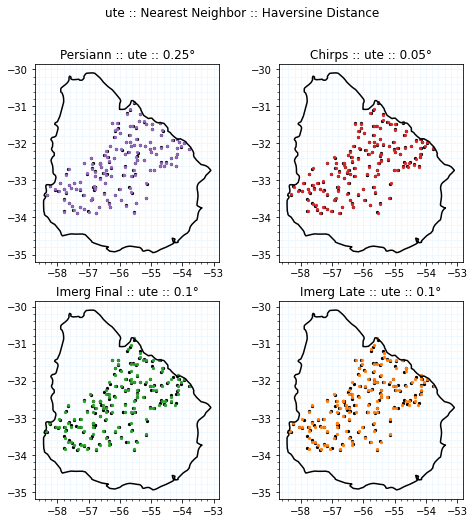

In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8)) 

# ute
geometry=[Point(xy) for xy in zip(df_ute_sbpp['lon'], df_ute_sbpp['lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)

df_geo_cells.plot(ax=axs[0,0], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[0,0], color="black")

df_geo_cells.plot(ax=axs[0,1], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[0,1], color="black")

df_geo_cells.plot(ax=axs[1,0], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[1,0], color="black")

df_geo_cells.plot(ax=axs[1,1], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[1,1], color="black")


# c4 persiann
axs[0,0].set_title('Persiann :: ute :: 0.25°');axs[0,0].grid(which='both', lw=1, color="aliceblue");axs[0,0].minorticks_on();axs[0,0].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_ute_sbpp['persiann_lon'], df_ute_sbpp['persiann_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[0,0], color='C4', markersize=5)

# c3 chirps
axs[0,1].set_title('Chirps :: ute :: 0.05°');axs[0,1].grid(which='both', lw=1, color="aliceblue");axs[0,1].minorticks_on();axs[0,1].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_ute_sbpp['chirps_lon'], df_ute_sbpp['chirps_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[0,1], color='C3', markersize=5) 


# c1 imerg final
axs[1,0].set_title('Imerg Final :: ute :: 0.1°');axs[1,0].grid(which='both', lw=1, color="aliceblue");axs[1,0].minorticks_on();axs[1,0].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_ute_sbpp['imerg_final_lon'], df_ute_sbpp['imerg_final_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[1,0], color='C2', markersize=5)

# c2 imerg late
axs[1,1].set_title('Imerg Late :: ute :: 0.1°');axs[1,1].grid(which='both', lw=1, color="aliceblue");axs[1,1].minorticks_on();axs[1,1].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_ute_sbpp['imerg_late_lon'], df_ute_sbpp['imerg_late_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[1,1], color='C1', markersize=5)


fig.suptitle(f'ute :: Nearest Neighbor :: Haversine Distance', fontsize=12)
plt.show()

##### Export Raw ute

In [40]:
file_pkl = dir_output+'/ute_sbpp_nearest_neighbors_2000_2020.pkl'
df_ute_sbpp.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive_output" 

#### INUMET

In [41]:
len(df_inumet_raw_lat_lon)


28

In [42]:
# inumet
df_inumet_sbpp = get_nearest_neighbor(df_inumet_raw_lat_lon, df_full_lat_lon_inumet, 'inumet')

# Persiann
df_inumet_sbpp = get_nearest_neighbor(df_inumet_sbpp, df_full_lat_lon_persiann, 'persiann')

# Chirps
df_inumet_sbpp = get_nearest_neighbor(df_inumet_sbpp, df_full_lat_lon_chirps, 'chirps')

# Imerg Final
df_inumet_sbpp = get_nearest_neighbor(df_inumet_sbpp, df_full_lat_lon_imerg_final, 'imerg_final')

# Imerg Late
df_inumet_sbpp = get_nearest_neighbor(df_inumet_sbpp, df_full_lat_lon_imerg_late, 'imerg_late')

df_inumet_sbpp.shape

(28, 23)

In [43]:
# ----------------------------------------------------------
# Es importante tener los mismos tipos de datos para los joins
# ----------------------------------------------------------
df_inumet_sbpp = df_inumet_sbpp.astype(np.float32,errors="ignore")  # <<---- CRITICO

In [44]:
df_inumet_sbpp

,lat,lon,source,inumet_lat,inumet_lon,inumet_distance,inumet_source,persiann_lat,persiann_lon,persiann_distance,...,chirps_distance,chirps_source,imerg_final_lat,imerg_final_lon,imerg_final_distance,imerg_final_source,imerg_late_lat,imerg_late_lon,imerg_late_distance,imerg_late_source
0,-34.493568,-54.312595,inumet,-34.493568,-54.312595,0.000119,inumet,-34.480000,-54.320000,1.205285,...,1.831654,chirps,-34.450001,-54.350002,5.028105,imerg_final,-34.450001,-54.350002,5.028105,imerg_late
1,-34.860653,-56.207386,inumet,-34.860653,-56.207386,0.000142,inumet,-34.880001,-56.200001,1.451342,...,2.150876,chirps,-34.849998,-56.249996,4.783708,imerg_final,-34.849998,-56.249996,4.783708,imerg_late
2,-33.536568,-56.915997,inumet,-33.536568,-56.915997,0.000110,inumet,-33.520000,-56.919998,1.099520,...,1.222970,chirps,-33.549999,-56.950001,3.867980,imerg_final,-33.549999,-56.950001,3.867980,imerg_late
3,-34.351875,-56.749672,inumet,-34.351875,-56.749672,0.000231,inumet,-34.360001,-56.759998,1.250665,...,3.083843,chirps,-34.349998,-56.749996,0.120134,imerg_final,-34.349998,-56.749996,0.120134,imerg_late
4,-33.459999,-55.630001,inumet,-33.459999,-55.630001,0.000132,inumet,-33.480000,-55.639999,1.676904,...,1.093028,chirps,-33.450001,-55.649998,2.310494,imerg_final,-33.450001,-55.649998,2.310494,imerg_late
5,-30.398214,-56.511780,inumet,-30.398214,-56.511780,0.000203,inumet,-30.400000,-56.520000,0.920827,...,2.046956,chirps,-30.349998,-56.549999,5.177355,imerg_final,-30.349998,-56.549999,5.177355,imerg_late
6,-34.164001,-58.032001,inumet,-34.164001,-58.032001,0.000187,inumet,-34.160000,-58.040001,0.920295,...,1.012414,chirps,-34.150002,-58.049999,2.164375,imerg_final,-34.150002,-58.049999,2.164375,imerg_late
7,-33.250515,-58.069077,inumet,-33.250515,-58.069077,0.000082,inumet,-33.240002,-58.080002,1.363073,...,1.583734,chirps,-33.250000,-58.049999,2.121488,imerg_final,-33.250000,-58.049999,2.121488,imerg_late
8,-33.351074,-56.502346,inumet,-33.351074,-56.502346,0.000104,inumet,-33.360001,-56.520000,2.038115,...,2.915666,chirps,-33.349998,-56.549999,5.299291,imerg_final,-33.349998,-56.549999,5.299291,imerg_late
9,-34.539841,-55.873581,inumet,-34.539841,-55.873581,0.000112,inumet,-34.520000,-55.880001,1.428737,...,0.939160,chirps,-34.549999,-55.850002,2.697280,imerg_final,-34.549999,-55.850002,2.697280,imerg_late


In [45]:
df_inumet_lat_lon = df_inumet_sbpp[['lat','lon']].drop_duplicates()

df_inumet_chirps_lat_lon = df_inumet_sbpp[['chirps_lat','chirps_lon']].drop_duplicates()
df_inumet_persiann_lat_lon = df_inumet_sbpp[['persiann_lat','persiann_lon']].drop_duplicates()
df_inumet_imerg_late_lat_lon = df_inumet_sbpp[['imerg_late_lat','imerg_late_lon']].drop_duplicates()
df_inumet_imerg_final_lat_lon = df_inumet_sbpp[['imerg_final_lat','imerg_final_lon']].drop_duplicates()

len(df_inumet_lat_lon), len(df_inumet_chirps_lat_lon), len(df_inumet_persiann_lat_lon), len(df_inumet_imerg_late_lat_lon), len(df_inumet_imerg_final_lat_lon)

(28, 28, 28, 28, 28)

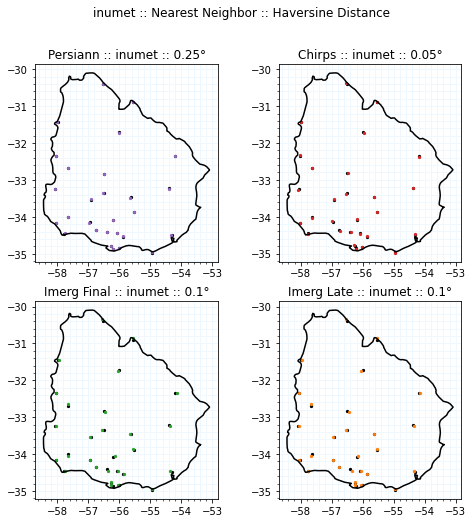

In [46]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8)) 

# inumet
geometry=[Point(xy) for xy in zip(df_inumet_sbpp['lon'], df_inumet_sbpp['lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)

df_geo_cells.plot(ax=axs[0,0], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[0,0], color="black")

df_geo_cells.plot(ax=axs[0,1], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[0,1], color="black")

df_geo_cells.plot(ax=axs[1,0], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[1,0], color="black")

df_geo_cells.plot(ax=axs[1,1], color='black', markersize=5)
geodf_shape.boundary.plot(ax=axs[1,1], color="black")


# c4 persiann
axs[0,0].set_title('Persiann :: inumet :: 0.25°');axs[0,0].grid(which='both', lw=1, color="aliceblue");axs[0,0].minorticks_on();axs[0,0].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_inumet_sbpp['persiann_lon'], df_inumet_sbpp['persiann_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[0,0], color='C4', markersize=5)

# c3 chirps
axs[0,1].set_title('Chirps :: inumet :: 0.05°');axs[0,1].grid(which='both', lw=1, color="aliceblue");axs[0,1].minorticks_on();axs[0,1].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_inumet_sbpp['chirps_lon'], df_inumet_sbpp['chirps_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[0,1], color='C3', markersize=5) 


# c1 imerg final
axs[1,0].set_title('Imerg Final :: inumet :: 0.1°');axs[1,0].grid(which='both', lw=1, color="aliceblue");axs[1,0].minorticks_on();axs[1,0].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_inumet_sbpp['imerg_final_lon'], df_inumet_sbpp['imerg_final_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[1,0], color='C2', markersize=5)

# c2 imerg late
axs[1,1].set_title('Imerg Late :: inumet :: 0.1°');axs[1,1].grid(which='both', lw=1, color="aliceblue");axs[1,1].minorticks_on();axs[1,1].set_axisbelow(True)
geometry=[Point(xy) for xy in zip(df_inumet_sbpp['imerg_late_lon'], df_inumet_sbpp['imerg_late_lat'])]
df_geo_cells = gpd.GeoDataFrame([],crs=crs, geometry=geometry)
df_geo_cells.plot(ax=axs[1,1], color='C1', markersize=5)


fig.suptitle(f'inumet :: Nearest Neighbor :: Haversine Distance', fontsize=12)
plt.show()

##### Export Raw inumet

In [47]:
file_pkl = dir_output+'/inumet_sbpp_nearest_neighbors_2000_2020.pkl'
df_inumet_sbpp.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive_output" 

## Reduce Gauges-Satellite Data 
 

In [48]:
# !rm -rf df* ds*

In [49]:
# ds_xr_chirps

### Export xArray to Parquet 

In [50]:
# List all active variables 
# %whos

In [51]:
# Exportamos a parquet para utilizar con SPARK, 
# NOTA: aqui no estan redondeados las coordenadas
# NOTA: voy a enviar los valores missing con np.nan ???

# Export to parke (Sparke)
export_xr_to_parquet(filename_chirps,dir_data+'/ds_xr_chirps.parquet.gzip',source="chirps")
export_xr_to_parquet(filename_imerg_late,dir_data+'/ds_xr_imerg_late.parquet.gzip',source="imerg_late",process_time=True)
export_xr_to_parquet(filename_imerg_final,dir_data+'/ds_xr_imerg_final.parquet.gzip',source="imerg_final",process_time=True)
export_xr_to_parquet(filename_persiann,dir_data+'/ds_xr_persiann.parquet.gzip',source="persiann")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


In [52]:

export_df_to_parquet(df_ute_sbpp,dir_data+'/df_ute_sbpp.parquet.gzip',source="ute_sbpp")
export_df_to_parquet(df_inumet_sbpp,dir_data+'/df_inumet_sbpp.parquet.gzip',source="inumet_sbpp")

In [53]:

export_xr_to_parquet(filename_inumet,dir_data+'/ds_xr_inumet.parquet.gzip',source="inumet")
export_xr_to_parquet(filename_ute,dir_data+'/ds_xr_ute.parquet.gzip',source="ute")


### Init Spark

In [54]:
spark = getSparkSession()
spark.stop()
spark = getSparkSession()

In [55]:
dspark_ds_xr_chirps = spark.read.load(dir_data+'/ds_xr_chirps.parquet.gzip')
dspark_ds_xr_imerg_late = spark.read.load(dir_data+'/ds_xr_imerg_late.parquet.gzip')
dspark_ds_xr_imerg_final = spark.read.load(dir_data+'/ds_xr_imerg_final.parquet.gzip')
dspark_ds_xr_persiann = spark.read.load(dir_data+'/ds_xr_persiann.parquet.gzip')

dspark_ds_xr_ute = spark.read.load(dir_data+'/ds_xr_ute.parquet.gzip')
dspark_ds_xr_inumet = spark.read.load(dir_data+'/ds_xr_inumet.parquet.gzip')

# Mapeo que calculamos con Hearvestian Distance 
dspark_df_ute_sbpp = spark.read.load(dir_data+'/df_ute_sbpp.parquet.gzip')
dspark_df_inumet_sbpp = spark.read.load(dir_data+'/df_inumet_sbpp.parquet.gzip')

In [56]:
digits_round_satellite = 3
digits_round_gauge = 4
# EJEcutarrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import col, round, bround


def my_round(ds_xr, col_name, decimals=3):
  return ds_xr.withColumn(col_name,round(ds_xr[col_name].cast(DoubleType()),decimals))
  # return ds_xr.withColumn(col_name+'x',round(ds_xr[col_name].cast(DoubleType()),decimals))
  # factor = 10**decimals
  # return ds_xr.withColumn(col_name, (factor * ds_xr[col_name]).cast(IntegerType())/factor )


import pyspark.sql.functions as func
def spark_lat_lon_float(ds_xr, decimals=3):
  ds_xr = my_round(ds_xr, 'lat', decimals)
  ds_xr = my_round(ds_xr, 'lon', decimals)
  return ds_xr

def gauge_sbpp_spark_lat_lon_float(ds_xr,gauge, decimals=3, gauge_decimals=4):
  ds_xr = my_round(ds_xr, gauge+"_lat", gauge_decimals)
  ds_xr = my_round(ds_xr, gauge+"_lon", gauge_decimals)

  for s in ['persiann','chirps','imerg_final','imerg_late']:
    ds_xr = my_round(ds_xr, s+"_lat", decimals)
    ds_xr = my_round(ds_xr, s+"_lon", decimals)
  return ds_xr

dspark_ds_xr_chirps       = spark_lat_lon_float(dspark_ds_xr_chirps, decimals=digits_round_satellite)
dspark_ds_xr_imerg_late   = spark_lat_lon_float(dspark_ds_xr_imerg_late, decimals=digits_round_satellite)
dspark_ds_xr_imerg_final  = spark_lat_lon_float(dspark_ds_xr_imerg_final, decimals=digits_round_satellite)
dspark_ds_xr_persiann     = spark_lat_lon_float(dspark_ds_xr_persiann, decimals=digits_round_satellite)

dspark_ds_xr_ute          = spark_lat_lon_float(dspark_ds_xr_ute, decimals=digits_round_gauge)
dspark_ds_xr_inumet       = spark_lat_lon_float(dspark_ds_xr_inumet, decimals=digits_round_gauge)

dspark_df_ute_sbpp        = spark_lat_lon_float(dspark_df_ute_sbpp, decimals=digits_round_gauge)
dspark_df_inumet_sbpp     = spark_lat_lon_float(dspark_df_inumet_sbpp, decimals=digits_round_gauge)

dspark_df_ute_sbpp        = gauge_sbpp_spark_lat_lon_float(dspark_df_ute_sbpp, 'ute', decimals=digits_round_satellite, gauge_decimals=digits_round_gauge)
dspark_df_inumet_sbpp     = gauge_sbpp_spark_lat_lon_float(dspark_df_inumet_sbpp, 'inumet', decimals=digits_round_satellite, gauge_decimals=digits_round_gauge)



In [57]:
dspark_ds_xr_chirps.createOrReplaceTempView('view_dspark_ds_xr_chirps')
dspark_ds_xr_imerg_late.createOrReplaceTempView('view_dspark_ds_xr_imerg_late')
dspark_ds_xr_imerg_final.createOrReplaceTempView('view_dspark_ds_xr_imerg_final')
dspark_ds_xr_persiann.createOrReplaceTempView('view_dspark_ds_xr_persiann')

dspark_ds_xr_ute.createOrReplaceTempView('view_dspark_ds_xr_ute')
dspark_ds_xr_inumet.createOrReplaceTempView('view_dspark_ds_xr_inumet')

dspark_df_ute_sbpp.createOrReplaceTempView('view_dspark_df_ute_sbpp')
dspark_df_inumet_sbpp.createOrReplaceTempView('view_dspark_df_inumet_sbpp')

In [58]:
dspark_ds_xr_chirps.select('*').show()
# dspark_ds_xr_imerg_late.select('*').show()
# dspark_ds_xr_imerg_final.select('*').show()
# dspark_ds_xr_persiann.select('*').show()


+-------------------+-------+-------+-------------+-------+
|               time|    lat|    lon|precipitation|_source|
+-------------------+-------+-------+-------------+-------+
|2000-01-01 00:00:00|-30.025|-58.975|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.925|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.875|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.825|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.775|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.725|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.675|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.625|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.575|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.525|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.475|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.425|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.375|          0.0| chirps|
|2000-01-01 00:00:00|-30.025|-58.325|   

In [59]:
dspark_ds_xr_ute.select('*').show()
# dspark_ds_xr_inumet.select('*').show()


+-------------------+--------+--------+-------------+-------+
|               time|     lat|     lon|precipitation|_source|
+-------------------+--------+--------+-------------+-------+
|2000-01-01 00:00:00|-30.8965|-55.5424|          0.0|    ute|
|2000-01-01 00:00:00|-31.1908|-55.7649|          0.0|    ute|
|2000-01-01 00:00:00|-31.2011|-55.3622|          0.0|    ute|
|2000-01-01 00:00:00| -31.394|-55.3944|       -598.0|    ute|
|2000-01-01 00:00:00|-31.4114| -55.239|          0.0|    ute|
|2000-01-01 00:00:00|-31.4556| -56.257|          0.0|    ute|
|2000-01-01 00:00:00|-31.4568|-56.0722|          0.0|    ute|
|2000-01-01 00:00:00| -31.468|-54.9615|          0.0|    ute|
|2000-01-01 00:00:00| -31.528|-55.6843|          0.0|    ute|
|2000-01-01 00:00:00|-31.5732|-55.4738|          0.0|    ute|
|2000-01-01 00:00:00|-31.5904|-56.0723|          0.0|    ute|
|2000-01-01 00:00:00|-31.6026|-54.9761|          0.0|    ute|
|2000-01-01 00:00:00|-31.6542| -56.152|          0.0|    ute|
|2000-01

In [60]:
dspark_df_ute_sbpp.select('*').show()
# dspark_df_inumet_sbpp.select('*').show()

+-----+--------+--------+------+--------+--------+------------+----------+------------+------------+-----------------+---------------+----------+----------+---------------+-------------+---------------+---------------+--------------------+------------------+--------------+--------------+-------------------+-----------------+--------+
|index|     lat|     lon|source| ute_lat| ute_lon|ute_distance|ute_source|persiann_lat|persiann_lon|persiann_distance|persiann_source|chirps_lat|chirps_lon|chirps_distance|chirps_source|imerg_final_lat|imerg_final_lon|imerg_final_distance|imerg_final_source|imerg_late_lat|imerg_late_lon|imerg_late_distance|imerg_late_source| _source|
+-----+--------+--------+------+--------+--------+------------+----------+------------+------------+-----------------+---------------+----------+----------+---------------+-------------+---------------+---------------+--------------------+------------------+--------------+--------------+-------------------+-----------------+--

### Merge Individual SBPP-Gauge

#### UTE

In [61]:
dspark_ds_xr_ute.count(), dspark_df_ute_sbpp.count()

(1032164, 140)

In [62]:
# UTE: Cantidad de registros 1032164 de 1032164
query = f"""
  SELECT  
    view_ute.*,

    view_ute_sbpp.ute_lat,view_ute_sbpp.ute_lon,
    view_ute_sbpp.chirps_lat,view_ute_sbpp.chirps_lon,
    view_ute_sbpp.imerg_late_lat,view_ute_sbpp.imerg_late_lon,
    view_ute_sbpp.imerg_final_lat,view_ute_sbpp.imerg_final_lon,
    view_ute_sbpp.persiann_lat,view_ute_sbpp.persiann_lon
  FROM
    view_dspark_ds_xr_ute as view_ute 
      inner join 
    view_dspark_df_ute_sbpp as view_ute_sbpp 
        on  view_ute.lat = view_ute_sbpp.ute_lat  and   
            view_ute.lon = view_ute_sbpp.ute_lon
 
 order by 
    time, lat, lon
"""

df_view_ute_ute = spark.sql(query)
df_view_ute_ute.write.parquet(dir_output+"df_view_ute_ute.parquet",mode="overwrite") 
df_view_ute_ute.show()


+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|               time|     lat|     lon|precipitation|_source| ute_lat| ute_lon|chirps_lat|chirps_lon|imerg_late_lat|imerg_late_lon|imerg_final_lat|imerg_final_lon|persiann_lat|persiann_lon|
+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|2000-01-01 00:00:00| -33.879|-56.7572|          0.0|    ute| -33.879|-56.7572|   -33.875|   -56.775|        -33.85|        -56.75|         -33.85|         -56.75|      -33.88|      -56.76|
|2000-01-01 00:00:00|-33.8724|  -57.37|          0.0|    ute|-33.8724|  -57.37|   -33.875|   -57.375|        -33.85|        -57.35|         -33.85|         -57.35|      -33.88|      -57.36|
|2000-01-01 00:00:00|-33.8626|-55.5492|          0

##### Persiann

In [63]:
dspark_ds_xr_persiann.count(), dspark_df_ute_sbpp.count()

(127408140, 140)

In [64]:
# PERSIANN: Cantidad de registros 1057929 de 127408140
query = f"""

    SELECT  
      view_persiann.*,

      view_ute_sbpp.persiann_lat,view_ute_sbpp.persiann_lon

    FROM
      view_dspark_ds_xr_persiann as view_persiann 
        inner join 
      view_dspark_df_ute_sbpp as view_ute_sbpp 
          on  view_persiann.lat = view_ute_sbpp.persiann_lat  and   
              view_persiann.lon = view_ute_sbpp.persiann_lon
    where 
      view_persiann.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_ute_persiann = spark.sql(query)
df_view_ute_persiann.write.parquet(dir_output+"df_view_ute_persiann.parquet",mode="overwrite") 
df_view_ute_persiann.show()


+-------------------+------+------+-------------+--------+------------+------------+
|               time|   lat|   lon|precipitation| _source|persiann_lat|persiann_lon|
+-------------------+------+------+-------------+--------+------------+------------+
|2000-03-01 00:00:00|-33.88|-57.36|          0.0|persiann|      -33.88|      -57.36|
|2000-03-01 00:00:00|-33.88|-56.76|          0.0|persiann|      -33.88|      -56.76|
|2000-03-01 00:00:00|-33.88|-55.56|          0.0|persiann|      -33.88|      -55.56|
|2000-03-01 00:00:00|-33.84| -57.8|          0.0|persiann|      -33.84|       -57.8|
|2000-03-01 00:00:00|-33.84| -57.0|          0.0|persiann|      -33.84|       -57.0|
|2000-03-01 00:00:00| -33.8|-57.48|          0.0|persiann|       -33.8|      -57.48|
|2000-03-01 00:00:00|-33.76|-57.16|          0.0|persiann|      -33.76|      -57.16|
|2000-03-01 00:00:00|-33.72|-57.28|          0.0|persiann|      -33.72|      -57.28|
|2000-03-01 00:00:00|-33.72|-56.68|          0.0|persiann|      -

##### Chirps

In [65]:
dspark_ds_xr_chirps.count(), dspark_df_ute_sbpp.count()

(85477953, 140)

In [66]:
# chirps: Cantidad de registros 1073940 de 85477953
query = f"""

    SELECT  
      view_chirps.*,

      view_ute_sbpp.chirps_lat,view_ute_sbpp.chirps_lon

    FROM
      view_dspark_ds_xr_chirps as view_chirps 
        inner join 
      view_dspark_df_ute_sbpp as view_ute_sbpp 
          on  view_chirps.lat = view_ute_sbpp.chirps_lat  and   
              view_chirps.lon = view_ute_sbpp.chirps_lon
    where 
      view_chirps.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_ute_chirps = spark.sql(query)
df_view_ute_chirps.write.parquet(dir_output+"df_view_ute_chirps.parquet",mode="overwrite") 
df_view_ute_chirps.show()


+-------------------+-------+-------+-------------+-------+----------+----------+
|               time|    lat|    lon|precipitation|_source|chirps_lat|chirps_lon|
+-------------------+-------+-------+-------------+-------+----------+----------+
|2000-01-01 00:00:00|-33.875|-57.375|          0.0| chirps|   -33.875|   -57.375|
|2000-01-01 00:00:00|-33.875|-56.775|          0.0| chirps|   -33.875|   -56.775|
|2000-01-01 00:00:00|-33.875|-55.525|          0.0| chirps|   -33.875|   -55.525|
|2000-01-01 00:00:00|-33.825|-57.775|          0.0| chirps|   -33.825|   -57.775|
|2000-01-01 00:00:00|-33.825|-57.025|          0.0| chirps|   -33.825|   -57.025|
|2000-01-01 00:00:00|-33.775|-57.475|          0.0| chirps|   -33.775|   -57.475|
|2000-01-01 00:00:00|-33.775|-57.175|          0.0| chirps|   -33.775|   -57.175|
|2000-01-01 00:00:00|-33.725|-57.275|          0.0| chirps|   -33.725|   -57.275|
|2000-01-01 00:00:00|-33.725|-56.675|          0.0| chirps|   -33.725|   -56.675|
|2000-01-01 00:0

##### Imerg Final

In [67]:
dspark_ds_xr_imerg_final.count(), dspark_df_ute_sbpp.count()

(22557000, 140)

In [68]:
# imerg_final: Cantidad de registros 1052660 de 22557000
query = f"""

    SELECT  
      view_imerg_final.*,

      view_ute_sbpp.imerg_final_lat,view_ute_sbpp.imerg_final_lon

    FROM
      view_dspark_ds_xr_imerg_final as view_imerg_final 
        inner join 
      view_dspark_df_ute_sbpp as view_ute_sbpp 
          on  view_imerg_final.lat = view_ute_sbpp.imerg_final_lat  and   
              view_imerg_final.lon = view_ute_sbpp.imerg_final_lon
    where 
      view_imerg_final.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_ute_imerg_final = spark.sql(query)
df_view_ute_imerg_final.write.parquet(dir_output+"df_view_ute_imerg_final.parquet",mode="overwrite") 
df_view_ute_imerg_final.show()


+-------------------+------+------+-------------+-----------+---------------+---------------+
|               time|   lat|   lon|precipitation|    _source|imerg_final_lat|imerg_final_lon|
+-------------------+------+------+-------------+-----------+---------------+---------------+
|2000-06-01 00:00:00|-33.85|-57.75|          0.0|imerg_final|         -33.85|         -57.75|
|2000-06-01 00:00:00|-33.85|-57.35|  0.015088794|imerg_final|         -33.85|         -57.35|
|2000-06-01 00:00:00|-33.85|-57.05|   0.03447513|imerg_final|         -33.85|         -57.05|
|2000-06-01 00:00:00|-33.85|-56.75| 0.0030338822|imerg_final|         -33.85|         -56.75|
|2000-06-01 00:00:00|-33.85|-55.55|  0.005439645|imerg_final|         -33.85|         -55.55|
|2000-06-01 00:00:00|-33.75|-57.45|  0.013027073|imerg_final|         -33.75|         -57.45|
|2000-06-01 00:00:00|-33.75|-57.25|          0.0|imerg_final|         -33.75|         -57.25|
|2000-06-01 00:00:00|-33.75|-57.15|          0.0|imerg_final

##### Imerg Late

In [69]:
dspark_ds_xr_imerg_late.count(), dspark_df_ute_sbpp.count()

(22557000, 140)

In [70]:
# imerg_late: Cantidad de registros 1052660 de 22557000
query = f"""

    SELECT  
      view_imerg_late.*,

      view_ute_sbpp.imerg_late_lat,view_ute_sbpp.imerg_late_lon

    FROM
      view_dspark_ds_xr_imerg_late as view_imerg_late 
        inner join 
      view_dspark_df_ute_sbpp as view_ute_sbpp 
          on  view_imerg_late.lat = view_ute_sbpp.imerg_late_lat  and   
              view_imerg_late.lon = view_ute_sbpp.imerg_late_lon
    where 
      view_imerg_late.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_ute_imerg_late = spark.sql(query)
df_view_ute_imerg_late.write.parquet(dir_output+"df_view_ute_imerg_late.parquet",mode="overwrite") 
df_view_ute_imerg_late.show()


+-------------------+------+------+-------------+----------+--------------+--------------+
|               time|   lat|   lon|precipitation|   _source|imerg_late_lat|imerg_late_lon|
+-------------------+------+------+-------------+----------+--------------+--------------+
|2000-06-01 00:00:00|-33.85|-57.75|          0.0|imerg_late|        -33.85|        -57.75|
|2000-06-01 00:00:00|-33.85|-57.35|  0.033843998|imerg_late|        -33.85|        -57.35|
|2000-06-01 00:00:00|-33.85|-57.05|   0.04368517|imerg_late|        -33.85|        -57.05|
|2000-06-01 00:00:00|-33.85|-56.75| 0.0039156503|imerg_late|        -33.85|        -56.75|
|2000-06-01 00:00:00|-33.85|-55.55|  0.002945676|imerg_late|        -33.85|        -55.55|
|2000-06-01 00:00:00|-33.75|-57.45|  0.026013764|imerg_late|        -33.75|        -57.45|
|2000-06-01 00:00:00|-33.75|-57.25|          0.0|imerg_late|        -33.75|        -57.25|
|2000-06-01 00:00:00|-33.75|-57.15|          0.0|imerg_late|        -33.75|        -57.15|

#### inumet

In [71]:
dspark_ds_xr_inumet.count(), dspark_df_inumet_sbpp.count()

(212845, 28)

In [72]:
# inumet: Cantidad de registros 212845 de 212845
query = f"""
  SELECT  
    view_inumet.*,

    view_inumet_sbpp.inumet_lat,view_inumet_sbpp.inumet_lon,
    view_inumet_sbpp.chirps_lat,view_inumet_sbpp.chirps_lon,
    view_inumet_sbpp.imerg_late_lat,view_inumet_sbpp.imerg_late_lon,
    view_inumet_sbpp.imerg_final_lat,view_inumet_sbpp.imerg_final_lon,
    view_inumet_sbpp.persiann_lat,view_inumet_sbpp.persiann_lon
  FROM
    view_dspark_ds_xr_inumet as view_inumet 
      inner join 
    view_dspark_df_inumet_sbpp as view_inumet_sbpp 
        on  view_inumet.lat = view_inumet_sbpp.inumet_lat  and   
            view_inumet.lon = view_inumet_sbpp.inumet_lon
 
 order by 
    time, lat, lon
"""

df_view_inumet_inumet = spark.sql(query)
df_view_inumet_inumet.write.parquet(dir_output+"df_view_inumet_inumet.parquet",mode="overwrite") 
df_view_inumet_inumet.show()


+-------------------+--------+--------+-------------+-------+----------+----------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|               time|     lat|     lon|precipitation|_source|inumet_lat|inumet_lon|chirps_lat|chirps_lon|imerg_late_lat|imerg_late_lon|imerg_final_lat|imerg_final_lon|persiann_lat|persiann_lon|
+-------------------+--------+--------+-------------+-------+----------+----------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|2000-01-01 00:00:00|-34.9689|-54.9512|          0.0| inumet|  -34.9689|  -54.9512|   -34.975|   -54.975|        -34.95|        -54.95|         -34.95|         -54.95|      -34.96|      -54.96|
|2000-01-01 00:00:00|-34.8607|-56.2074|          0.0| inumet|  -34.8607|  -56.2074|   -34.875|   -56.225|        -34.85|        -56.25|         -34.85|         -56.25|      -34.88|       -56.2|
|2000-01-01 00:00:00|-34.8329|

##### Persiann

In [73]:
dspark_ds_xr_persiann.count(), dspark_df_inumet_sbpp.count()

(127408140, 28)

In [74]:
# PERSIANN: Cantidad de registros 197886 de 127408140
query = f"""

    SELECT  
      view_persiann.*,

      view_inumet_sbpp.persiann_lat,view_inumet_sbpp.persiann_lon

    FROM
      view_dspark_ds_xr_persiann as view_persiann 
        inner join 
      view_dspark_df_inumet_sbpp as view_inumet_sbpp 
          on  view_persiann.lat = view_inumet_sbpp.persiann_lat  and   
              view_persiann.lon = view_inumet_sbpp.persiann_lon
    where 
      view_persiann.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_inumet_persiann = spark.sql(query)
df_view_inumet_persiann.write.parquet(dir_output+"df_view_inumet_persiann.parquet",mode="overwrite") 
df_view_inumet_persiann.show()


+-------------------+------+------+-------------+--------+------------+------------+
|               time|   lat|   lon|precipitation| _source|persiann_lat|persiann_lon|
+-------------------+------+------+-------------+--------+------------+------------+
|2000-03-01 00:00:00|-34.88| -56.2|          0.0|persiann|      -34.88|       -56.2|
|2000-03-01 00:00:00| -34.8|-56.28|          0.0|persiann|       -34.8|      -56.28|
|2000-03-01 00:00:00|-34.52|-55.88|          0.0|persiann|      -34.52|      -55.88|
|2000-03-01 00:00:00|-34.48|-54.32|          0.0|persiann|      -34.48|      -54.32|
|2000-03-01 00:00:00|-34.44|-57.76|          1.0|persiann|      -34.44|      -57.76|
|2000-03-01 00:00:00|-34.44|-56.08|          0.0|persiann|      -34.44|      -56.08|
|2000-03-01 00:00:00| -34.4| -56.4|          0.0|persiann|       -34.4|       -56.4|
|2000-03-01 00:00:00|-34.36|-56.76|          0.0|persiann|      -34.36|      -56.76|
|2000-03-01 00:00:00|-34.16|-58.04|          0.0|persiann|      -

##### Chirps

In [75]:
dspark_ds_xr_chirps.count(), dspark_df_inumet_sbpp.count()

(85477953, 28)

In [76]:
# chirps: Cantidad de registros 214788 de 85477953
query = f"""

    SELECT  
      view_chirps.*,

      view_inumet_sbpp.chirps_lat,view_inumet_sbpp.chirps_lon

    FROM
      view_dspark_ds_xr_chirps as view_chirps 
        inner join 
      view_dspark_df_inumet_sbpp as view_inumet_sbpp 
          on  view_chirps.lat = view_inumet_sbpp.chirps_lat  and   
              view_chirps.lon = view_inumet_sbpp.chirps_lon
    where 
      view_chirps.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_inumet_chirps = spark.sql(query)
df_view_inumet_chirps.write.parquet(dir_output+"df_view_inumet_chirps.parquet",mode="overwrite") 
df_view_inumet_chirps.show()


+-------------------+-------+-------+-------------+-------+----------+----------+
|               time|    lat|    lon|precipitation|_source|chirps_lat|chirps_lon|
+-------------------+-------+-------+-------------+-------+----------+----------+
|2000-01-01 00:00:00|-34.975|-54.975|          0.0| chirps|   -34.975|   -54.975|
|2000-01-01 00:00:00|-34.875|-56.225|          0.0| chirps|   -34.875|   -56.225|
|2000-01-01 00:00:00|-34.825|-56.025|          0.0| chirps|   -34.825|   -56.025|
|2000-01-01 00:00:00|-34.775|-56.275|          0.0| chirps|   -34.775|   -56.275|
|2000-01-01 00:00:00|-34.525|-55.875|          0.0| chirps|   -34.525|   -55.875|
|2000-01-01 00:00:00|-34.475|-57.775|          0.0| chirps|   -34.475|   -57.775|
|2000-01-01 00:00:00|-34.475|-56.075|          0.0| chirps|   -34.475|   -56.075|
|2000-01-01 00:00:00|-34.475|-54.325|          0.0| chirps|   -34.475|   -54.325|
|2000-01-01 00:00:00|-34.425|-56.375|          0.0| chirps|   -34.425|   -56.375|
|2000-01-01 00:0

##### Imerg Final

In [77]:
dspark_ds_xr_imerg_final.count(), dspark_df_inumet_sbpp.count()

(22557000, 28)

In [78]:
# imerg_final: Cantidad de registros 210532 de 22557000
query = f"""

    SELECT  
      view_imerg_final.*,

      view_inumet_sbpp.imerg_final_lat,view_inumet_sbpp.imerg_final_lon

    FROM
      view_dspark_ds_xr_imerg_final as view_imerg_final 
        inner join 
      view_dspark_df_inumet_sbpp as view_inumet_sbpp 
          on  view_imerg_final.lat = view_inumet_sbpp.imerg_final_lat  and   
              view_imerg_final.lon = view_inumet_sbpp.imerg_final_lon
    where 
      view_imerg_final.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_inumet_imerg_final = spark.sql(query)
df_view_inumet_imerg_final.write.parquet(dir_output+"df_view_inumet_imerg_final.parquet",mode="overwrite") 
df_view_inumet_imerg_final.show()


+-------------------+------+------+-------------+-----------+---------------+---------------+
|               time|   lat|   lon|precipitation|    _source|imerg_final_lat|imerg_final_lon|
+-------------------+------+------+-------------+-----------+---------------+---------------+
|2000-06-01 00:00:00|-34.95|-54.95|  0.018890923|imerg_final|         -34.95|         -54.95|
|2000-06-01 00:00:00|-34.85|-56.25|   0.08336871|imerg_final|         -34.85|         -56.25|
|2000-06-01 00:00:00|-34.85|-56.05|    0.1930829|imerg_final|         -34.85|         -56.05|
|2000-06-01 00:00:00|-34.75|-56.25|  0.023611309|imerg_final|         -34.75|         -56.25|
|2000-06-01 00:00:00|-34.55|-55.85|  0.020205222|imerg_final|         -34.55|         -55.85|
|2000-06-01 00:00:00|-34.45|-57.75| 0.0044375844|imerg_final|         -34.45|         -57.75|
|2000-06-01 00:00:00|-34.45|-56.35|  0.010238376|imerg_final|         -34.45|         -56.35|
|2000-06-01 00:00:00|-34.45|-56.05|  0.016333181|imerg_final

##### Imerg Late

In [79]:
dspark_ds_xr_imerg_late.count(), dspark_df_inumet_sbpp.count()

(22557000, 28)

In [80]:
# imerg_late: Cantidad de registros 210532 de 22557000
query = f"""

    SELECT  
      view_imerg_late.*,

      view_inumet_sbpp.imerg_late_lat,view_inumet_sbpp.imerg_late_lon

    FROM
      view_dspark_ds_xr_imerg_late as view_imerg_late 
        inner join 
      view_dspark_df_inumet_sbpp as view_inumet_sbpp 
          on  view_imerg_late.lat = view_inumet_sbpp.imerg_late_lat  and   
              view_imerg_late.lon = view_inumet_sbpp.imerg_late_lon
    where 
      view_imerg_late.precipitation >= 0    -- Traigo solo los que tienen datos
    order by 
      time, lat, lon

"""

df_view_inumet_imerg_late = spark.sql(query)
df_view_inumet_imerg_late.write.parquet(dir_output+"df_view_inumet_imerg_late.parquet",mode="overwrite") 
df_view_inumet_imerg_late.show()


+-------------------+------+------+-------------+----------+--------------+--------------+
|               time|   lat|   lon|precipitation|   _source|imerg_late_lat|imerg_late_lon|
+-------------------+------+------+-------------+----------+--------------+--------------+
|2000-06-01 00:00:00|-34.95|-54.95|          0.0|imerg_late|        -34.95|        -54.95|
|2000-06-01 00:00:00|-34.85|-56.25|   0.07302502|imerg_late|        -34.85|        -56.25|
|2000-06-01 00:00:00|-34.85|-56.05|   0.20369281|imerg_late|        -34.85|        -56.05|
|2000-06-01 00:00:00|-34.75|-56.25|  0.014561724|imerg_late|        -34.75|        -56.25|
|2000-06-01 00:00:00|-34.55|-55.85|  0.012141969|imerg_late|        -34.55|        -55.85|
|2000-06-01 00:00:00|-34.45|-57.75|          0.0|imerg_late|        -34.45|        -57.75|
|2000-06-01 00:00:00|-34.45|-56.35|          0.0|imerg_late|        -34.45|        -56.35|
|2000-06-01 00:00:00|-34.45|-56.05|  0.020619733|imerg_late|        -34.45|        -56.05|

## Merge Gauges-Satellite Data


In [81]:
# %whos

# del dspark_df_inumet_sbpp
# del dspark_df_ute_sbpp
# del dspark_ds_xr_chirps
# del dspark_ds_xr_imerg_final
# del dspark_ds_xr_imerg_late
# del dspark_ds_xr_inumet
# del dspark_ds_xr_persiann
# del dspark_ds_xr_ute

# del df_ute_sbpp
# del df_view_inumet_chirps
# del df_view_inumet_imerg_final
# del df_view_inumet_imerg_late
# del df_view_inumet_inumet
# del df_view_inumet_persiann
# del df_view_ute_chirps
# del df_view_ute_imerg_final
# del df_view_ute_imerg_late
# del df_view_ute_persiann
# del df_view_ute_ute
# del df_inumet_sbpp

##### Spark

In [82]:
spark.stop()
spark = getSparkSession()

In [83]:
# ute
dspark_df_view_ute_ute = spark.read.load(dir_output+'/df_view_ute_ute.parquet')
dspark_df_view_ute_chirps = spark.read.load(dir_output+'/df_view_ute_chirps.parquet')
dspark_df_view_ute_imerg_late = spark.read.load(dir_output+'/df_view_ute_imerg_late.parquet')
dspark_df_view_ute_imerg_final = spark.read.load(dir_output+'/df_view_ute_imerg_final.parquet')
dspark_df_view_ute_persiann = spark.read.load(dir_output+'/df_view_ute_persiann.parquet')


# inumet
dspark_df_view_inumet_inumet = spark.read.load(dir_output+'/df_view_inumet_inumet.parquet') 
dspark_df_view_inumet_chirps = spark.read.load(dir_output+'/df_view_inumet_chirps.parquet')
dspark_df_view_inumet_imerg_late = spark.read.load(dir_output+'/df_view_inumet_imerg_late.parquet')
dspark_df_view_inumet_imerg_final = spark.read.load(dir_output+'/df_view_inumet_imerg_final.parquet')
dspark_df_view_inumet_persiann = spark.read.load(dir_output+'/df_view_inumet_persiann.parquet')


In [84]:
# Revisar porque hay duplicados
# ute
dspark_df_view_ute_ute = dspark_df_view_ute_ute.drop_duplicates()
dspark_df_view_ute_chirps = dspark_df_view_ute_chirps.drop_duplicates()
dspark_df_view_ute_imerg_late = dspark_df_view_ute_imerg_late.drop_duplicates()
dspark_df_view_ute_imerg_final = dspark_df_view_ute_imerg_final.drop_duplicates()
dspark_df_view_ute_persiann = dspark_df_view_ute_persiann.drop_duplicates()


# inumet
dspark_df_view_inumet_inumet = dspark_df_view_inumet_inumet.drop_duplicates()
dspark_df_view_inumet_chirps = dspark_df_view_inumet_chirps.drop_duplicates()
dspark_df_view_inumet_imerg_late = dspark_df_view_inumet_imerg_late.drop_duplicates()
dspark_df_view_inumet_imerg_final = dspark_df_view_inumet_imerg_final.drop_duplicates()
dspark_df_view_inumet_persiann = dspark_df_view_inumet_persiann.drop_duplicates()

In [85]:
dspark_df_view_ute_ute.select('*').show(3)

+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|               time|     lat|     lon|precipitation|_source| ute_lat| ute_lon|chirps_lat|chirps_lon|imerg_late_lat|imerg_late_lon|imerg_final_lat|imerg_final_lon|persiann_lat|persiann_lon|
+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+
|2000-01-01 00:00:00|-33.6604| -55.794|          0.0|    ute|-33.6604| -55.794|   -33.675|   -55.775|        -33.65|        -55.75|         -33.65|         -55.75|      -33.68|       -55.8|
|2000-01-01 00:00:00|-32.3965|-56.9144|          0.0|    ute|-32.3965|-56.9144|   -32.375|   -56.925|        -32.35|        -56.95|         -32.35|         -56.95|       -32.4|      -56.92|
|2000-01-02 00:00:00|-32.5372|-55.5029|          0

In [86]:
# ute
dspark_df_view_ute_ute.createOrReplaceTempView('view_dspark_df_view_ute_ute')
dspark_df_view_ute_chirps.createOrReplaceTempView('view_dspark_df_view_ute_chirps')
dspark_df_view_ute_imerg_late.createOrReplaceTempView('view_dspark_df_view_ute_imerg_late')
dspark_df_view_ute_imerg_final.createOrReplaceTempView('view_dspark_df_view_ute_imerg_final')
dspark_df_view_ute_persiann.createOrReplaceTempView('view_dspark_df_view_ute_persiann')
# inumet
dspark_df_view_inumet_inumet.createOrReplaceTempView('view_dspark_df_view_inumet_inumet')
dspark_df_view_inumet_chirps.createOrReplaceTempView('view_dspark_df_view_inumet_chirps')
dspark_df_view_inumet_imerg_late.createOrReplaceTempView('view_dspark_df_view_inumet_imerg_late')
dspark_df_view_inumet_imerg_final.createOrReplaceTempView('view_dspark_df_view_inumet_imerg_final')
dspark_df_view_inumet_persiann.createOrReplaceTempView('view_dspark_df_view_inumet_persiann')
 

In [87]:
# dspark_df_view_ute_ute.select('*').show()
# type(dspark_df_view_ute_ute)
dspark_df_view_ute_ute.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- _source: string (nullable = true)
 |-- ute_lat: double (nullable = true)
 |-- ute_lon: double (nullable = true)
 |-- chirps_lat: double (nullable = true)
 |-- chirps_lon: double (nullable = true)
 |-- imerg_late_lat: double (nullable = true)
 |-- imerg_late_lon: double (nullable = true)
 |-- imerg_final_lat: double (nullable = true)
 |-- imerg_final_lon: double (nullable = true)
 |-- persiann_lat: double (nullable = true)
 |-- persiann_lon: double (nullable = true)



##### UTE

In [88]:
# UTE: cantidad de registros 1032164
query = f"""
  SELECT
     view_ute.*,

     view_chirps.precipitation as chirps_precipitation ,
     view_persiann.precipitation as persiann_precipitation ,
     view_imerg_final.precipitation as imerg_final_precipitation ,
     view_imerg_late.precipitation as imerg_late_precipitation  
    
  FROM
    view_dspark_df_view_ute_ute as view_ute 
       left join 
    view_dspark_df_view_ute_chirps as view_chirps 
        on  view_chirps.chirps_lat = view_ute.chirps_lat and 
            view_chirps.chirps_lon = view_ute.chirps_lon and 
            view_chirps.time = view_ute.time
       left join 
    view_dspark_df_view_ute_persiann as view_persiann 
        on  view_persiann.persiann_lat = view_ute.persiann_lat and 
            view_persiann.persiann_lon = view_ute.persiann_lon and 
            view_persiann.time = view_ute.time
       left join 
    view_dspark_df_view_ute_imerg_final as view_imerg_final 
        on  view_imerg_final.imerg_final_lat = view_ute.imerg_final_lat and 
            view_imerg_final.imerg_final_lon = view_ute.imerg_final_lon and 
            view_imerg_final.time = view_ute.time
       left join 
    view_dspark_df_view_ute_imerg_late as view_imerg_late 
        on  view_imerg_late.imerg_late_lat = view_ute.imerg_late_lat and 
            view_imerg_late.imerg_late_lon = view_ute.imerg_late_lon and 
            view_imerg_late.time = view_ute.time
order by 
  time, lat, lon
"""
 

df_view_ute_sbpp_2000_2020 = spark.sql(query)
df_view_ute_sbpp_2000_2020.write.parquet(dir_output+"/df_view_ute_sbpp_2000_2020.parquet",mode="overwrite") 
df_view_ute_sbpp_2000_2020.show()


+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+--------------------+----------------------+-------------------------+------------------------+
|               time|     lat|     lon|precipitation|_source| ute_lat| ute_lon|chirps_lat|chirps_lon|imerg_late_lat|imerg_late_lon|imerg_final_lat|imerg_final_lon|persiann_lat|persiann_lon|chirps_precipitation|persiann_precipitation|imerg_final_precipitation|imerg_late_precipitation|
+-------------------+--------+--------+-------------+-------+--------+--------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+--------------------+----------------------+-------------------------+------------------------+
|2000-01-01 00:00:00| -33.879|-56.7572|          0.0|    ute| -33.879|-56.7572|   -33.875|   -56.775|        -33.85|        -56.75|         -33.8

###### Export

In [89]:
pd_view_ute_sbpp_2000_2020 = pd.read_parquet(dir_output+'/df_view_ute_sbpp_2000_2020.parquet')
file_pkl = dir_output+'/view_ute_sbpp_2000_2020.pkl'
pd_view_ute_sbpp_2000_2020.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive_output" 

##### Inumet

In [90]:
# Inumet: 212845
query = f"""
  SELECT
     view_inumet.*,

     view_chirps.precipitation as chirps_precipitation ,
     view_persiann.precipitation as persiann_precipitation ,
     view_imerg_final.precipitation as imerg_final_precipitation ,
     view_imerg_late.precipitation as imerg_late_precipitation  
    
  FROM
    view_dspark_df_view_inumet_inumet as view_inumet 
       left join 
    view_dspark_df_view_inumet_chirps as view_chirps 
        on  view_chirps.chirps_lat = view_inumet.chirps_lat and 
            view_chirps.chirps_lon = view_inumet.chirps_lon and 
            view_chirps.time = view_inumet.time
       left join 
    view_dspark_df_view_inumet_persiann as view_persiann 
        on  view_persiann.persiann_lat = view_inumet.persiann_lat and 
            view_persiann.persiann_lon = view_inumet.persiann_lon and 
            view_persiann.time = view_inumet.time
       left join 
    view_dspark_df_view_inumet_imerg_final as view_imerg_final 
        on  view_imerg_final.imerg_final_lat = view_inumet.imerg_final_lat and 
            view_imerg_final.imerg_final_lon = view_inumet.imerg_final_lon and 
            view_imerg_final.time = view_inumet.time
       left join 
    view_dspark_df_view_inumet_imerg_late as view_imerg_late 
        on  view_imerg_late.imerg_late_lat = view_inumet.imerg_late_lat and 
            view_imerg_late.imerg_late_lon = view_inumet.imerg_late_lon and 
            view_imerg_late.time = view_inumet.time
order by 
  time, lat, lon
"""

df_view_inumet_sbpp_2000_2020 = spark.sql(query)
df_view_inumet_sbpp_2000_2020.write.parquet(dir_output+"/df_view_inumet_sbpp_2000_2020.parquet",mode="overwrite") 
df_view_inumet_sbpp_2000_2020.show()


+-------------------+--------+--------+-------------+-------+----------+----------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+--------------------+----------------------+-------------------------+------------------------+
|               time|     lat|     lon|precipitation|_source|inumet_lat|inumet_lon|chirps_lat|chirps_lon|imerg_late_lat|imerg_late_lon|imerg_final_lat|imerg_final_lon|persiann_lat|persiann_lon|chirps_precipitation|persiann_precipitation|imerg_final_precipitation|imerg_late_precipitation|
+-------------------+--------+--------+-------------+-------+----------+----------+----------+----------+--------------+--------------+---------------+---------------+------------+------------+--------------------+----------------------+-------------------------+------------------------+
|2000-01-01 00:00:00|-34.9689|-54.9512|          0.0| inumet|  -34.9689|  -54.9512|   -34.975|   -54.975|        -34.95|        -54.9

###### Export

In [91]:
pd_view_inumet_sbpp_2000_2020 = pd.read_parquet(dir_output+'/df_view_inumet_sbpp_2000_2020.parquet')
file_pkl = dir_output+'/view_inumet_sbpp_2000_2020.pkl'
pd_view_inumet_sbpp_2000_2020.to_pickle(file_pkl,compression='gzip')
!cp "$file_pkl" "$dir_google_drive_output" 